<a href="https://colab.research.google.com/github/q1mora/cnt-property-prediction-using-ml-architectures/blob/main/chirality_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time

# set manual seeds
seed = 43
np.random.seed(seed)
torch.manual_seed(seed)

# configuration (batch_size, num_epochs, learning_rate)
batch_size = 32
num_epochs = 300
learning_rate = 0.0001


Text(0.5, 1.0, 'distribution of metallicity (0 and 1)')

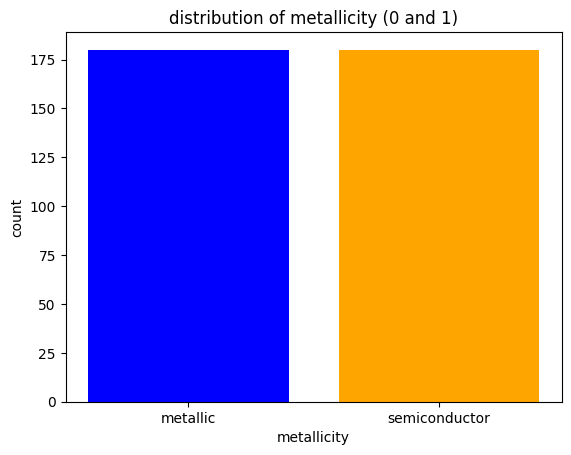

In [128]:
# load in dataset
data = pd.read_csv('/content/Chirality_Indices_Data_.csv')  # change filename

# count how many 0s and 1s
counts = data['metallicity'].value_counts().sort_index()  # ensures 0 then 1 order

# plot the bar chart
plt.bar(counts.index.astype(str), counts.values, color=['blue', 'orange'])
plt.xticks([0, 1], ['metallic', 'semiconductor'])

plt.xlabel('metallicity')
plt.ylabel('count')
plt.title('distribution of metallicity (0 and 1)')



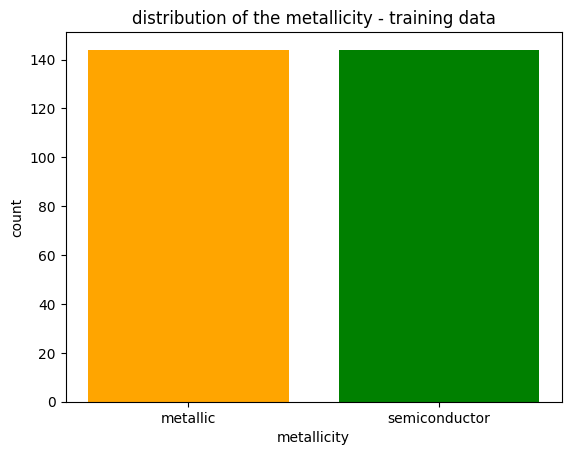

In [129]:
features = ['n', 'm', 'modulus']
target = 'metallicity'

x = data[features].values
y = data[target].values


# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=seed, stratify=y
)

unique, counts = np.unique(y_train, return_counts=True)

# plot training data
plt.bar(unique.astype(str), counts, color=['orange', 'green'])
plt.xticks([0, 1], ['metallic', 'semiconductor'])

plt.xlabel('metallicity')
plt.ylabel('count')
plt.title('distribution of the metallicity - training data')

plt.savefig('distribution_of_metallicity_training')


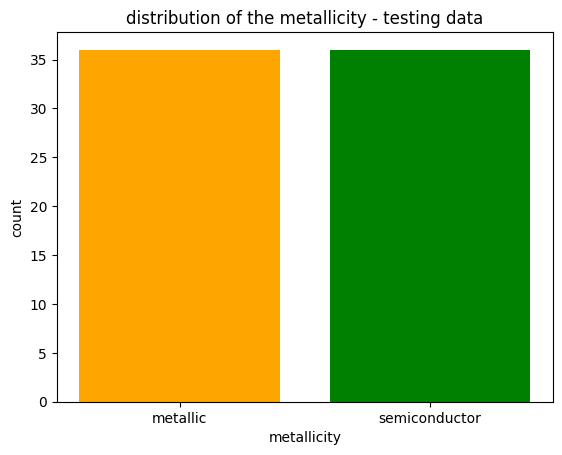

In [130]:
unique, counts = np.unique(y_test, return_counts=True)

# plot testing data
plt.bar(unique.astype(str), counts, color=['orange', 'green'])
plt.xticks([0, 1], ['metallic', 'semiconductor'])

plt.xlabel('metallicity')
plt.ylabel('count')
plt.title('distribution of the metallicity - testing data')

plt.savefig('distribution_of_metallicity_testing')

In [131]:
# preprocess and split data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


# create pytorch dataloaders
# convert data to pytorch tensors
# we need y to be a float and reshaped for the loss function
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)


x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)


# create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# define the mlp model
class mlp_model(nn.Module):
  def __init__(self):
    super(mlp_model, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(3, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU()
    )

    # output layer (1 output: 'metallicity' logit)
    self.output_layer = nn.Linear(64, 1)

  def forward(self, x):
    x = self.net(x)
    x = self.output_layer(x)
    return x


In [132]:
# checking for GPU and set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

# creating model and using it to the device
model = mlp_model().to(device)
print(model)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


using device: cuda
mlp_model(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [133]:
print('start training')
start_time = time.time()

# training
for epoch in range(num_epochs):
  model.train()
  for features, labels in train_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)
    loss = criterion(outputs, labels)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if (epoch +1) % 10 == 0:
    print(f'epoch [{epoch+1}/{num_epochs}], loss: {loss.item(): .4f}')

end_time = time.time()
print('training finished')

total_training_time = end_time - start_time
print(f'total training time: {total_training_time: .2f} seconds')



start training
epoch [10/300], loss:  0.5218
epoch [20/300], loss:  0.1812
epoch [30/300], loss:  0.0395
epoch [40/300], loss:  0.0225
epoch [50/300], loss:  0.0113
epoch [60/300], loss:  0.0061
epoch [70/300], loss:  0.0036
epoch [80/300], loss:  0.0024
epoch [90/300], loss:  0.0022
epoch [100/300], loss:  0.0019
epoch [110/300], loss:  0.0012
epoch [120/300], loss:  0.0010
epoch [130/300], loss:  0.0009
epoch [140/300], loss:  0.0007
epoch [150/300], loss:  0.0006
epoch [160/300], loss:  0.0005
epoch [170/300], loss:  0.0005
epoch [180/300], loss:  0.0004
epoch [190/300], loss:  0.0004
epoch [200/300], loss:  0.0003
epoch [210/300], loss:  0.0004
epoch [220/300], loss:  0.0003
epoch [230/300], loss:  0.0002
epoch [240/300], loss:  0.0002
epoch [250/300], loss:  0.0002
epoch [260/300], loss:  0.0002
epoch [270/300], loss:  0.0001
epoch [280/300], loss:  0.0001
epoch [290/300], loss:  0.0001
epoch [300/300], loss:  0.0001
training finished
total training time:  5.40 seconds


In [134]:
# testing
print('start testing\n')
model.eval()
correct = 0
total = 0

print('start testing (inference)\n')
inference_start_time = time.time()

with torch.no_grad():
  for features, labels in test_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)

    # getting predictions
    predicted = torch.round(torch.sigmoid(outputs))

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

inference_end_time = time.time()

accuracy = 100 * correct / total
print(f'accuracy of the model on the {total} test samples: {accuracy: .2f} %\n')

# printing inference time resuts
total_inference_time = inference_end_time - inference_start_time
avg_inference_time_per_sample = (total_inference_time / total) * 1000 # in milliseconds

print(f'total inference time for {total} samples: {total_inference_time: .4f} seconds\n')
print(f'average inference time per sample: {avg_inference_time_per_sample: .4f} ms')

start testing

start testing (inference)

accuracy of the model on the 72 test samples:  100.00 %

total inference time for 72 samples:  0.0036 seconds

average inference time per sample:  0.0494 ms


baseline accuracy (unshuffled):  100.00 %
------------------------------
testing importance of: n
accuracy after shuffling:  100.00
importance (accuracy drop):  0.00
testing importance of: m
accuracy after shuffling:  100.00
importance (accuracy drop):  0.00
testing importance of: modulus
accuracy after shuffling:  61.11
importance (accuracy drop):  38.89
feature importance plot


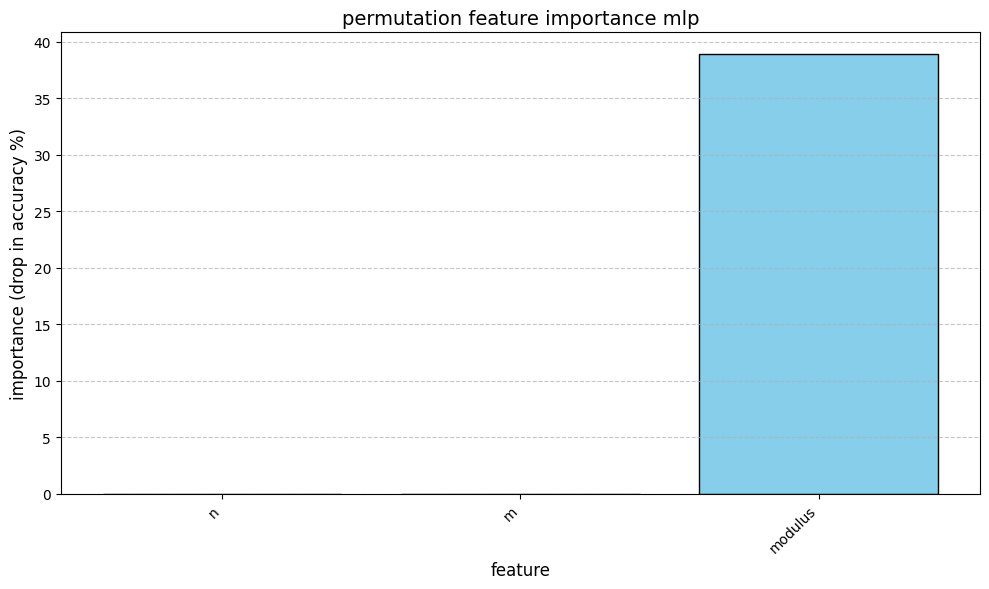

In [135]:
# class balance report (permutation instance)
def get_accuracy(x_data, y_data):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    outputs = model(x_data)
    predicted = torch.round(torch.sigmoid(outputs))
    total = y_data.size(0)
    correct = (predicted == y_data).sum().item()
  return 100 * correct / total

# getting baseline accuracy
baseline_accuracy = get_accuracy(x_test_tensor, y_test_tensor)
print(f"baseline accuracy (unshuffled): {baseline_accuracy: .2f} %")
print('-' * 30)

feature_names = ['n', 'm', 'modulus']
importances = []

for i in range(x_test_tensor.shape[1]):
  print(f"testing importance of: {feature_names[i]}")
  x_test_shuffled = x_test_tensor.clone()

  # shuffle only column 'i'
  perm_indices = torch.randperm(x_test_shuffled.size(0))
  x_test_shuffled[:, i] = x_test_shuffled[perm_indices, i]

  shuffled_accuracy = get_accuracy(x_test_shuffled, y_test_tensor)
  print(f"accuracy after shuffling: {shuffled_accuracy: .2f}")

  importance = baseline_accuracy - shuffled_accuracy
  importances.append(importance)
  print(f"importance (accuracy drop): {importance: .2f}")

print('feature importance plot')
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color='skyblue', edgecolor='black')
plt.xlabel('feature', fontsize=12)
plt.ylabel('importance (drop in accuracy %)', fontsize=12)
plt.title('permutation feature importance mlp', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('mlp_feature_importance.png')




confusion matrix:
[[36  0]
 [ 0 36]]


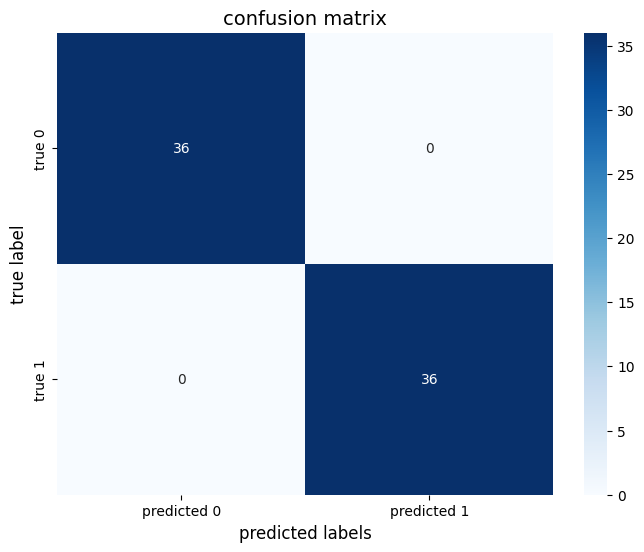

In [136]:
# creating a 2 x 2 (confusion matrix)

model.eval()
with torch.no_grad():
  # getting predictions for the entire test set
  all_outputs = model(x_test_tensor.to(device))
  all_preds_rounded = torch.round(torch.sigmoid(all_outputs))

  # move tensors to cpu
  y_pred = all_preds_rounded.cpu().numpy().ravel()
  y_true = y_test_tensor.cpu().numpy().ravel()

# creating a confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("confusion matrix:")
print(cm)

# plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['predicted 0', 'predicted 1'],
            yticklabels=['true 0', 'true 1'])

plt.xlabel('predicted labels', fontsize=12)
plt.ylabel('true label', fontsize=12)
plt.title('confusion matrix', fontsize=14)
plt.savefig('confusion_matrix.png')


In [137]:
# define the class names for a clearer repoty
target_names = ['semiconducting (0)', 'metallic (1)']


# generate the report
report = classification_report(y_true, y_pred, target_names=target_names)

print('classification report')
print(report)

classification report
                    precision    recall  f1-score   support

semiconducting (0)       1.00      1.00      1.00        36
      metallic (1)       1.00      1.00      1.00        36

          accuracy                           1.00        72
         macro avg       1.00      1.00      1.00        72
      weighted avg       1.00      1.00      1.00        72



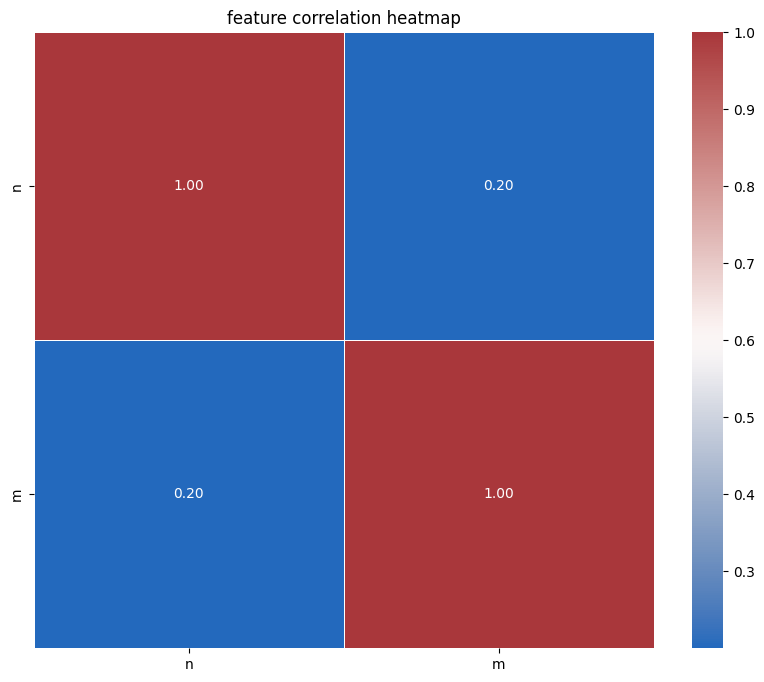

In [138]:
corr_matrix = data[['n', 'm']].corr()

# creating heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='vlag',
            fmt='.2f',
            linewidths=0.5)


plt.title('feature correlation heatmap')
plt.savefig('feature_correlation_heatmap.png')
plt.show()

In [139]:
model_check = mlp_model()

# counting parameters
total_params = sum(p.numel() for p in model_check.parameters() if p.requires_grad)

print("model complexity:\n")
print(f"total trainable parameters in the mlp: {total_params}")

model complexity:

total trainable parameters in the mlp: 25345
